In [1]:
!pip install xgboost
!pip install colorama==0.4.4
!pip install bayesian-optimization==1.4.0
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

# Configuration

In [34]:
# Config for the XG Boost Testing

# Where You Store the folder
Folder_Path = "C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Result"

# TimeFrame List & Included Test Currencies
tf_list = ["1M", "3M"]
curr_list = ["USD", "JPY", "GBP", "CHF","AUD", "CAD", "NZD", "NOK", "SEK", "EUR"]
exp_return_threshold = 0 # When exp.return > threshold -> Classified as 1

# ML Metrics - Use as a *kwargs to initialize ML Variable in XGBoost Classifier
model_training_parameters = {
    'learning_rate': 0.2, 
    'gamma': 0.2, 
    'reg_alpha': 0.1,
    'objective': 'binary:logistic',
    'random_state': 4010,
}

# Additional Choices
default_threshold = 0
activate_search_threshold = False
predict_direction = "IRP" # PPP/IRP
drop_fe_list = ["start_date", "end_date", "realized_spot","initial_spot", "expected_spot", "expected_ret", "spot_error_pct"] # Initial Spots, Realized Spots, You may drop as many as you like (Sample Columns is as below)
time_lag = 2 # Will loop through shift 1, 2, ....(time_lag) as user inputs
time_lag_dict = {"1M":5, "3M":1}
predict_period_after = 1 # Use latest data to predict whether label after kth period will rise.

In [35]:
# Variable Adjustment

# Generated cross product of currency list
curr_pair_1 = curr_list
curr_pair_2 = curr_list
gen = ((x, y) for x in curr_pair_1 for y in curr_pair_2 if x != y)

# predict_direction - Later Implementation
# dir_from = predict_direction.split('-')[0]
# dir_to = predict_direction.split('-')[1]

In [36]:
#reading treasury rate

treasury_dict = {}
G_10 = curr_list
Maturity = tf_list

for currency in G_10:
    for maturity in Maturity:
        
        if currency == 'USD':
            ticker = 'USGG' + maturity + ' Index'
        else:
            ticker = 'GT'+ currency + maturity + ' Govt'
        try:
            treasury_data_df = pd.read_csv('C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Treasury Rate\\' 
                                        + ticker + '.csv', header = 1, index_col = 0)
            treasury_dict[currency+'_'+maturity] = treasury_data_df
        except:
            treasury_dict[currency+'_'+maturity] = None


# Predefined function for later step

In [37]:
def feature_engine(result_df, time_lag):
    req_col = result_df.columns
    for col in req_col:
        if col == "label":
            continue
        for i in range(1, time_lag + 1):
            result_df[f"{col}_shift{i}"] = result_df[col].shift(i)
    return result_df

def label_result(result_df, threshold = default_threshold):
    # Here you can add any label as you want...
    result_df["label"] = np.where(result_df["realized_ret"] > threshold, 1, 0)
    result_df["label"] = result_df["label"].shift(-predict_period_after)
    
    return result_df

def get_best_params(result_df):
    result_df = result_df.dropna()
    # set training parameters and label & split the testing set.
    X = result_df.drop(columns = ["label"])
    Y = result_df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    # Optimize the machine learning parameter
    # print(X_train, y_train)
    def xgb_cv(learning_rate, max_depth):
        params = {'learning_rate': learning_rate, 'max_depth': int(max_depth), 'objective': 'binary:logistic'}
        cv_result = xgb.XGBClassifier(**params).fit(X_train, y_train).predict_proba(X_test)[:,1]
        return f1_score(y_test, (cv_result > 0.5).astype(int))
    # Set up the Bayesian optimizer
    pbounds = {'learning_rate': (0.01, 1.0), 'max_depth': (1, 10)}
    optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)

    # Run the optimization loop
    optimizer.maximize(init_points=5, n_iter=10)
    best_params = optimizer.max['params']
    best_params["max_depth"] = int(best_params["max_depth"])
    return best_params

def get_best_classification(result_df):
    result_df = result_df.dropna()
    
    X = result_df
    Y = np.where(result_df["realized_ret"] > default_threshold, 1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y)

    def optimize_cf(threshold):
        param = {'threshold': threshold}
        return f1_score(y_train, (X_train["realized_ret"] > threshold).astype(int))
    pbounds = {'threshold': (-0.005, 0.005)}
    
    optimizer = BayesianOptimization(f=optimize_cf, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=10)
    
    results = optimizer.res
    filtered_results = [result for result in results if result['target'] != 1.0]
    best_params = max(filtered_results, key=lambda x: x['target'])['params']["threshold"]
    # best_params = optimizer.max['params']
    return best_params

def trainXGModel(result_df, best_params):
    result_df = result_df.dropna()
    # set training parameters and label & split the testing set.
    X = result_df.drop(columns = ["label"])
    Y = result_df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)
    
    # Fit the model
    model = xgb.XGBClassifier(**model_training_parameters)
    # model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    
    # Get the feature importance object
    tmp_df = pd.DataFrame(model.feature_importances_.reshape(1, -1), columns=X.columns)
    obj = tmp_df.to_dict(orient='records')[0]
    
    # Predict the model 
    y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index)
    accuracy = accuracy_score(y_test, y_pred)
    
    return (accuracy, obj, y_pred)

# Main Logic 

In [38]:
#Econ_Accuracy_Study
econ_accuracy_1M_df = pd.DataFrame()
econ_accuracy_3M_df = pd.DataFrame()
econ_accuracy_1M_df.index = accuracy_df.columns
econ_accuracy_3M_df.index = accuracy_df.columns

In [49]:
#Flag to control which case to fit in
with_realized_ret = True
with_econ_data = True

In [50]:
if with_econ_data:
    drop_fe_list = ["start_date", "end_date", "realized_spot","initial_spot", "expected_spot", "expected_ret", "spot_error_pct"]
else:
    drop_fe_list = ["start_date", "end_date", "realized_spot","initial_spot", "expected_spot", "expected_ret", "spot_error_pct","spread", "base_econ", "pricing_econ"]

In [51]:
gen = ((x, y) for x in curr_pair_1 for y in curr_pair_2 if x != y)

accuracy_df = pd.DataFrame()
accuracy_df.index = tf_list
feature_importance_df = pd.DataFrame()
feature_importance_df.index = tf_list

for c1, c2 in gen:
    across_pair_df_1M = pd.DataFrame()
    across_pair_df_3M = pd.DataFrame()
    
    acc_ls = []
    fe_importance_ls = []
    
    for tf in tf_list:
        time_lag = time_lag_dict[tf]
        try:
            # 1. Access file and create df
            
            result_df = pd.read_csv(f'{Folder_Path}\\{predict_direction}\\{c1 + c2}\\Data Details\\{tf}.csv', index_col=0)
            result_df.index = result_df["end_date"]
            
            if predict_direction == "PPP":
                result_df.index = pd.to_datetime(result_df.index)

                tmp = pd.read_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Data\\CPI\\{c1}.csv', index_col=0, header = 1)
                tmp.index = pd.to_datetime(tmp.index)
                result_df['base_econ'] = tmp["Last_Price"].resample(tf).last()

                tmp = pd.read_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Data\\CPI\\{c2}.csv', index_col=0, header = 1)
                tmp.index = pd.to_datetime(tmp.index)
                result_df['pricing_econ'] = tmp["Last_Price"].resample(tf).last()
                
            elif predict_direction == "IRP":
                tmp = treasury_dict[c1+'_'+tf]
                result_df['base_econ'] = tmp["Last_Price"].loc[result_df['start_date']]

                tmp = treasury_dict[c2+'_'+tf]
                result_df['pricing_econ'] = tmp["Last_Price"].loc[result_df['start_date']]               
                


            # tmp = pd.read_csv(f'C:/Users/johnn/Downloads/Currency_Data/{c1 + c2}.csv', index_col=0)
            # tmp.index = pd.to_datetime(tmp.index)
            # result_df[c1 + c2] = tmp["Last_Price"].resample(tf).last()
            
            result_df.index = result_df["end_date"]
            #labelling
            result_df = label_result(result_df)
            if not with_realized_ret:
                result_df = result_df.drop(columns=["realized_ret"])
            # 2.1 Drop unnecessary columns
            result_df = result_df.drop(columns=drop_fe_list)
            # 2.2 Feature Engineering
            result_df = feature_engine(result_df, time_lag)
            
            # print(result_df, threshold)
            # 3. Train & Test Model
            print(c1, c2)
            best_params = get_best_params(result_df) # Train the best ML Metrics using Bayesian Search
            accuracy, fe_obj, y_pred = trainXGModel(result_df, best_params)
            
            y_pred.to_csv(f"C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_Prediction\\{predict_direction}_{c1+c2}_{tf}_shift{predict_period_after}.csv")
            # 4. Append the objects
            acc_ls.append(accuracy)
            fe_importance_ls.append(fe_obj)

            # 5. Concat all the same tf obj
            concatenated_df = pd.concat([result_df, eval(f"across_pair_df_{tf}")])
            globals()[f"across_pair_df_{tf}"] = concatenated_df
        except:
            acc_ls.append(np.NaN)
            fe_importance_ls.append(np.NaN)
    accuracy_df[c1 + c2] = acc_ls
    feature_importance_df[c1 + c2] = fe_importance_ls

USD JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.7273    | 0.3808    | 9.556     |
| 2         | 0.5       | 0.7347    | 6.388     |
| 3         | 0.7273    | 0.1645    | 2.404     |
| 4         | 0.6667    | 0.0675    | 8.796     |
| 5         | 0.6667    | 0.6051    | 7.373     |
| 6         | 0.7273    | 0.2307    | 9.515     |
| 7         | 0.7143    | 0.02596   | 1.253     |
| 8         | 0.5714    | 0.9997    | 1.683     |
| 9         | 0.0       | 0.01      | 3.197     |
| 10        | 0.5714    | 0.01      | 1.88      |
| 11        | 0.5455    | 0.6787    | 9.063     |
| 12        | 0.7273    | 0.1715    | 10.0      |
| 13        | 0.6154    | 0.8428    | 10.0      |
| 14        | 0.7273    | 0.1679    | 2.417     |
| 15        | 0.1818    | 0.01332   | 7.918     |
USD JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.5455    | 0.3808  

| 15        | 0.4       | 0.6933    | 2.102     |
USD NZD
USD NOK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.8235    | 0.3808    | 9.556     |
| 2         | 0.75      | 0.7347    | 6.388     |
| 3         | 0.9412    | 0.1645    | 2.404     |
| 4         | 0.9412    | 0.0675    | 8.796     |
| 5         | 0.8235    | 0.6051    | 7.373     |
| 6         | 0.8235    | 0.6762    | 5.777     |
| 7         | 0.875     | 0.01      | 8.739     |
| 8         | 0.875     | 0.1103    | 5.695     |
| 9         | 0.9412    | 0.1338    | 8.831     |
| 10        | 0.875     | 0.03575   | 8.935     |
| 11        | 0.8889    | 0.2237    | 2.521     |
| 12        | 0.8889    | 0.4474    | 8.419     |
| 13        | 0.9412    | 0.04567   | 2.393     |
| 14        | 0.9412    | 0.06192   | 8.805     |
| 15        | 0.9412    | 0.1224    | 2.238     |
USD SEK
|   iter    |  target   | learni... | max_depth |
--------------------------

| 13        | 0.4       | 1.0       | 2.487     |
| 14        | 0.4       | 0.6809    | 1.627     |
| 15        | 0.8       | 0.7813    | 1.073     |
GBP JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.5       | 0.3808    | 9.556     |
| 2         | 0.5       | 0.7347    | 6.388     |
| 3         | 0.5       | 0.1645    | 2.404     |
| 4         | 0.5       | 0.0675    | 8.796     |
| 5         | 0.2857    | 0.6051    | 7.373     |
| 6         | 0.5       | 0.1089    | 2.322     |
| 7         | 0.5       | 0.8454    | 5.534     |
| 8         | 0.5       | 0.01      | 5.8       |
| 9         | 0.6667    | 1.0       | 1.567     |
| 10        | 0.6667    | 1.0       | 1.0       |
| 11        | 0.6667    | 0.2216    | 1.0       |
| 12        | 0.5       | 1.0       | 3.777     |
| 13        | 0.6667    | 0.5882    | 1.312     |
| 14        | 0.5714    | 0.9922    | 2.234     |
| 15        | 0.6667    | 0.6059    | 1.0 

C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\skl

| 3         | 0.0       | 0.1645    | 2.404     |
| 4         | 0.0       | 0.0675    | 8.796     |
| 5         | 0.0       | 0.6051    | 7.373     |
| 6         | 0.0       | 0.9919    | 1.008     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 7         | 0.0       | 0.9984    | 1.004     |
| 8         | 0.0       | 0.08388   | 10.0      |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 9         | 0.0       | 0.01119   | 1.016     |
| 10        | 0.0       | 0.9959    | 9.999     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 11        | 0.0       | 0.9652    | 1.003     |
| 12        | 0.0       | 0.9166    | 9.998     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 13        | 0.0       | 0.05485   | 1.015     |
| 14        | 0.0       | 0.0568    | 9.995     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 15        | 0.0       | 0.04508   | 1.002     |
GBP CAD
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.25      | 0.3808    | 9.556     |
| 2         | 0.25      | 0.7347    | 6.388     |
| 3         | 0.25      | 0.1645    | 2.404     |
| 4         | 0.25      | 0.0675    | 8.796     |
| 5         | 0.25      | 0.6051    | 7.373     |
| 6         | 0.25      | 0.9919    | 1.008     |
| 7         | 0.25      | 0.9984    | 1.004     |
| 8         | 0.25      | 0.08388   | 10.0      |
| 9         | 0.8571    | 0.01119   | 1.016     |
| 10        | 0.8571    | 0.01      | 1.321     |
| 11        | 0.25      | 1.0       | 4.441     |
| 12        | 0.25      | 0.1898    | 1.166     |
| 13        | 0.8571    | 0.01      | 1.169     |
| 14        | 0.8571    | 0.02147   | 1.486     |
| 15        | 0.8571    | 0.0198    | 1.756     |
GBP NZD
GBP NOK
|   iter    |  target   | learni... | max_depth |
--------------------------

| 14        | 0.0       | 0.0568    | 9.995     |
| 15        | 0.0       | 0.04508   | 1.002     |
AUD CAD
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\skl

| 1         | 0.0       | 0.3808    | 9.556     |
| 2         | 0.0       | 0.7347    | 6.388     |
| 3         | 0.0       | 0.1645    | 2.404     |
| 4         | 0.0       | 0.0675    | 8.796     |
| 5         | 0.0       | 0.6051    | 7.373     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 6         | 0.0       | 0.9919    | 1.008     |
| 7         | 0.0       | 0.9984    | 1.004     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 8         | 0.0       | 0.08388   | 10.0      |
| 9         | 0.0       | 0.01119   | 1.016     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 10        | 0.0       | 0.9959    | 9.999     |
| 11        | 0.0       | 0.9652    | 1.003     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 12        | 0.0       | 0.9166    | 9.998     |
| 13        | 0.0       | 0.05485   | 1.015     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 14        | 0.0       | 0.0568    | 9.995     |
| 15        | 0.0       | 0.04508   | 1.002     |
AUD NOK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.0       | 0.3808    | 9.556     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\skl

| 2         | 0.0       | 0.7347    | 6.388     |
| 3         | 0.0       | 0.1645    | 2.404     |
| 4         | 0.0       | 0.0675    | 8.796     |
| 5         | 0.0       | 0.6051    | 7.373     |
| 6         | 0.0       | 0.9919    | 1.008     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 7         | 0.0       | 0.9984    | 1.004     |
| 8         | 0.0       | 0.08388   | 10.0      |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 9         | 0.0       | 0.01119   | 1.016     |
| 10        | 0.0       | 0.9959    | 9.999     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 11        | 0.0       | 0.9652    | 1.003     |
| 12        | 0.0       | 0.9166    | 9.998     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 13        | 0.0       | 0.05485   | 1.015     |
| 14        | 0.0       | 0.0568    | 9.995     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 15        | 0.0       | 0.04508   | 1.002     |
AUD SEK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.0       | 0.3808    | 9.556     |
| 2         | 0.0       | 0.7347    | 6.388     |
| 3         | 0.0       | 0.1645    | 2.404     |
| 4         | 0.0       | 0.0675    | 8.796     |
| 5         | 0.0       | 0.6051    | 7.373     |
| 6         | 0.0       | 0.9919    | 1.008     |
| 7         | 0.0       | 0.9984    | 1.004     |
| 8         | 0.0       | 0.08388   | 10.0      |
| 9         | 0.0       | 0.01119   | 1.016     |
| 10        | 0.0       | 0.9959    | 9.999     |
| 11        | 0.0       | 0.9652    | 1.003     |
| 12        | 0.0       | 0.9166    | 9.998     |
| 13        | 0.0       | 0.05485   | 1.015     |
| 14        | 0.0       | 0.0568    | 9.995     |
| 15        | 0.0       | 0.04508   | 1.002     |
CAD JPY
|   iter    |  target   | learni... | max_depth |
----------------------------------

| 13        | 0.5333    | 0.6993    | 5.143     |
| 14        | 0.5714    | 0.4012    | 5.386     |
| 15        | 0.6667    | 0.9084    | 5.394     |
EUR JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.6667    | 0.3808    | 9.556     |
| 2         | 0.5833    | 0.7347    | 6.388     |
| 3         | 0.6667    | 0.1645    | 2.404     |
| 4         | 0.6667    | 0.0675    | 8.796     |
| 5         | 0.6667    | 0.6051    | 7.373     |
| 6         | 0.6667    | 0.09714   | 2.304     |
| 7         | 0.75      | 1.0       | 8.259     |
| 8         | 0.75      | 1.0       | 8.79      |
| 9         | 0.7692    | 1.0       | 1.0       |
| 10        | 0.7407    | 0.1837    | 1.004     |
| 11        | 0.7692    | 1.0       | 1.645     |
| 12        | 0.6957    | 1.0       | 3.921     |
| 13        | 0.7692    | 0.7436    | 1.315     |
| 14        | 0.7692    | 0.9987    | 1.342     |
| 15        | 0.64      | 1.0       | 2.34

# General Insight

<AxesSubplot:>

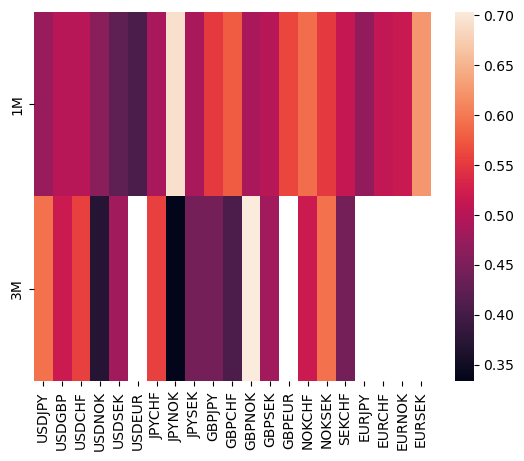

In [211]:
sns.heatmap(accuracy_df.dropna(axis=1, how='all'))

In [212]:
accuracy_df.dropna(axis=1, how='all')

,USDJPY,USDGBP,USDCHF,USDNOK,USDSEK,USDEUR,JPYCHF,JPYNOK,JPYSEK,GBPJPY,...,GBPNOK,GBPSEK,GBPEUR,NOKCHF,NOKSEK,SEKCHF,EURJPY,EURCHF,EURNOK,EURSEK
1M,0.474359,0.500000,0.500000,0.461538,0.423077,0.40625,0.487179,0.692308,0.487179,0.551282,...,0.487179,0.500000,0.561404,0.589744,0.551282,0.512821,0.46875,0.508772,0.515625,0.625
3M,0.592593,0.518519,0.555556,0.370370,0.481481,NaN,0.555556,0.333333,0.444444,0.444444,...,0.703704,0.481481,NaN,0.518519,0.592593,0.444444,NaN,NaN,NaN,NaN


In [78]:
feature_importance_df

,USDJPY,USDGBP,USDCHF,USDAUD,USDCAD,USDNZD,USDNOK,USDSEK,USDEUR,JPYUSD,...,SEKEUR,EURUSD,EURJPY,EURGBP,EURCHF,EURAUD,EURCAD,EURNZD,EURNOK,EURSEK
1M,"{'spread': 0.05714033171534538, 'realized_ret'...","{'spread': 0.031669553369283676, 'realized_ret...","{'spread': 0.05093296617269516, 'realized_ret'...",NaN,NaN,NaN,"{'spread': 0.03748622164130211, 'realized_ret'...","{'spread': 0.040283139795064926, 'realized_ret...","{'spread': 0.03780299425125122, 'realized_ret'...",NaN,...,NaN,NaN,"{'spread': 0.03689361736178398, 'realized_ret'...",NaN,"{'spread': 0.038316648453474045, 'realized_ret...",NaN,NaN,NaN,"{'spread': 0.035798873752355576, 'realized_ret...","{'spread': 0.03519736975431442, 'realized_ret'..."
3M,"{'spread': 0.10660505294799805, 'realized_ret'...","{'spread': 0.12184016406536102, 'realized_ret'...","{'spread': 0.09553217142820358, 'realized_ret'...",NaN,NaN,NaN,"{'spread': 0.10515162348747253, 'realized_ret'...","{'spread': 0.1767932027578354, 'realized_ret':...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
feature_importance_df['USDJPY'].loc['1M']

{'spread': 0.0,
 'realized_ret': 0.06391826272010803,
 'base_econ': 0.017826111987233162,
 'pricing_econ': 0.03552258014678955,
 'spread_shift1': 0.2838641405105591,
 'spread_shift2': 0.07849013060331345,
 'spread_shift3': 0.10492026060819626,
 'spread_shift4': 0.0,
 'spread_shift5': 0.03707727789878845,
 'realized_ret_shift1': 0.028635216876864433,
 'realized_ret_shift2': 0.016030294820666313,
 'realized_ret_shift3': 0.05413103103637695,
 'realized_ret_shift4': 0.014756434597074986,
 'realized_ret_shift5': 0.0,
 'base_econ_shift1': 0.02378549426794052,
 'base_econ_shift2': 0.013678515329957008,
 'base_econ_shift3': 0.0,
 'base_econ_shift4': 0.0,
 'base_econ_shift5': 0.05583516135811806,
 'pricing_econ_shift1': 0.026896590366959572,
 'pricing_econ_shift2': 0.014710388146340847,
 'pricing_econ_shift3': 0.0913783386349678,
 'pricing_econ_shift4': 0.038543879985809326,
 'pricing_econ_shift5': 0.0}

In [213]:
accuracy_df.T["1M"].nlargest(10)

JPYNOK    0.692308
EURSEK    0.625000
NOKCHF    0.589744
GBPCHF    0.576923
GBPEUR    0.561404
GBPJPY    0.551282
NOKSEK    0.551282
EURNOK    0.515625
SEKCHF    0.512821
EURCHF    0.508772
Name: 1M, dtype: float64

In [53]:
econ_accuracy_1M_df["both"] = accuracy_df.T["1M"]
econ_accuracy_3M_df["both"] = accuracy_df.T["3M"]

In [54]:
econ_accuracy_1M_df.mean(axis = 0)

ret_only          0.480093
econ_data_only    0.475516
both              0.495281
dtype: float64

In [55]:
econ_accuracy_3M_df.mean(axis = 0)

ret_only          0.556875
econ_data_only    0.526309
both              0.520222
dtype: float64

In [56]:
econ_accuracy_1M_df.to_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_Econ_Data_Importance\\{predict_direction}_1M.csv')
econ_accuracy_3M_df.to_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_Econ_Data_Importance\\{predict_direction}_3M.csv')

<AxesSubplot:title={'center':'1M'}>

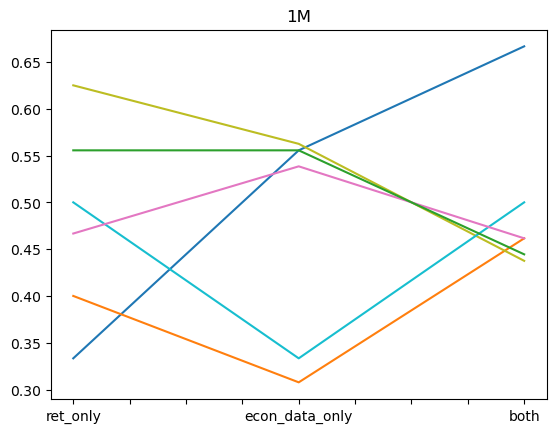

In [57]:
econ_accuracy_1M_df.T.plot(title = '1M',legend = False)

<AxesSubplot:title={'center':'3M'}>

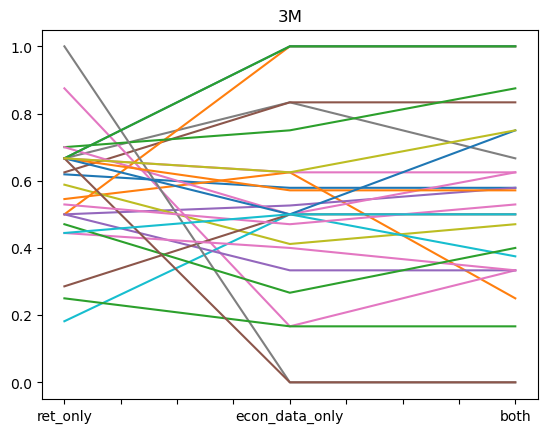

In [58]:
econ_accuracy_3M_df.T.plot(title = '3M',legend = False)